In [1]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.session import SparkSession
from pyspark.sql.types import *

spark = SparkSession.builder.appName("Spark NLP").master("local[4]").config("spark.driver.memory","12G").config("spark.driver.maxResultSize", "0").config("spark.kryoserializer.buffer.max", "2000M").config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.3.2").getOrCreate()
sc = spark.sparkContext

:: loading settings :: url = jar:file:/usr/local/lib/python3.9/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/user/.ivy2/cache
The jars for the packages stored in: /Users/user/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e02c8e67-9bfe-4f18-bdd5-2c1445479fe6;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;3.3.2 in central
	found com.typesafe#config;1.4.1 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.603 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok

In [2]:
schema = StructType([
    StructField("vid", StringType(), True),
    StructField("text", StringType(), True),
    StructField("likes", IntegerType(), True),
])

df_comments_base = spark.read.schema(schema).format("csv").option("header",True).option("encoding", "utf-8").load("./comments.csv")
df_comments_base.show()

+-----------+--------------------+-----+
|        vid|                text|likes|
+-----------+--------------------+-----+
|HlEFrbLeDks|I&#39;m vaccine a...|    1|
|HlEFrbLeDks|Hi from the futur...|    1|
|HlEFrbLeDks|He will always be...|    0|
|HlEFrbLeDks|I remember watchi...|    0|
|HlEFrbLeDks|Introverts were l...|    4|
|HlEFrbLeDks|         Good times.|    0|
|HlEFrbLeDks|The beginning of ...|    3|
|HlEFrbLeDks|This must never h...|    0|
|HlEFrbLeDks|Watching this a y...|    2|
|HlEFrbLeDks|One year on and I...|    0|
|HlEFrbLeDks|I didnt mind stay...|    2|
|HlEFrbLeDks|Tomorrow marks on...|    3|
|HlEFrbLeDks|Can’t believe it’...|    7|
|HlEFrbLeDks|This was the wors...|    1|
|HlEFrbLeDks|here we are lockd...|    0|
|HlEFrbLeDks|The day it all we...|    5|
|HlEFrbLeDks|What happens if i...|    1|
|HlEFrbLeDks|  This is soo COOOOL|    0|
|HlEFrbLeDks|Interesting to re...|    2|
|HlEFrbLeDks|9 months later an...|    1|
+-----------+--------------------+-----+
only showing top

In [3]:
df_comments_base = df_comments_base.filter(col("likes") >= 0)
df_comments_base = df_comments_base.withColumn("rank", row_number().over(Window.partitionBy(col("vid")).orderBy(desc(col("likes"))))).filter(col("rank") <= 20)
df_comments_base.show()

+-----------+--------------------+-----+----+
|        vid|                text|likes|rank|
+-----------+--------------------+-----+----+
|LyiUHxD3S8s|Six brain cells i...|  156|   1|
|LyiUHxD3S8s|It&#39;s not maki...|  135|   2|
|LyiUHxD3S8s|The snitches shou...|   81|   3|
|LyiUHxD3S8s|Soo everyone arou...|   78|   4|
|LyiUHxD3S8s|If you are the so...|   76|   5|
|LyiUHxD3S8s|making it up as w...|   71|   6|
|LyiUHxD3S8s|Fake news<br>Gove...|   67|   7|
|LyiUHxD3S8s|0.1% death rate o...|   47|   8|
|LyiUHxD3S8s|It&#39;s simple, ...|   39|   9|
|LyiUHxD3S8s|And Grouse shoote...|   31|  10|
|LyiUHxD3S8s|&quot;People shou...|   26|  11|
|LyiUHxD3S8s|Anyone noticed ho...|   25|  12|
|LyiUHxD3S8s|There&#39;s six o...|   24|  13|
|LyiUHxD3S8s|Bollocks to the g...|   23|  14|
|LyiUHxD3S8s|Clearly &quot;The...|   18|  15|
|LyiUHxD3S8s|make your voice h...|   15|  16|
|LyiUHxD3S8s|Unless you&#39;re...|   13|  17|
|LyiUHxD3S8s|Another power tri...|   13|  18|
|LyiUHxD3S8s|I&#39;ve got a ch...|

In [4]:
vschema = StructType([
    StructField("index_label", StringType(), True),
    StructField("channelId", StringType(), True),
    StructField("channelTitle", StringType(), True),
    StructField("videoId", StringType(), True),
    StructField("videoTitle", StringType(), True),
    StructField("description", StringType(), True),
    StructField("link", StringType(), True),
    StructField("time", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("day", IntegerType(), True)
])

df_bbc = spark.read.schema(vschema).format("csv").option("header",True).option("encoding", "utf-8").load("./final/BBC_videos_final.csv")
df_bbc = df_bbc.select(col("videoId"), col("year"), col("month"), col("day"))
df_bbc = df_bbc.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("BBC"))

df_guardian = spark.read.schema(vschema).format("csv").option("header",True).option("encoding", "utf-8").load("./final/Guardian_videos_final.csv")
df_guardian = df_guardian.filter(col("channelId") != "na").select(col("videoId"), col("year"), col("month"), col("day")).filter(col("videoId") != "#NAME?")
df_guardian = df_guardian.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("Guardian"))
df_guardian.show()

+-----------+--------+--------+
|    videoId|    Date|    from|
+-----------+--------+--------+
|8bUCwmYcvzY|20200323|Guardian|
|Ml-1hUISPj8|20200323|Guardian|
|ZD4PYP6eayQ|20200324|Guardian|
|x5XT8H5PLzQ|20200329|Guardian|
|x2axKYqLXso|20200416|Guardian|
|RVHKA3BKpBo|20200416|Guardian|
|CCOnQAmbDNc|20200430|Guardian|
|Y7hYnZnSliI|20200430|Guardian|
|WRs-dC-gmVk|20200510|Guardian|
|PPhf8LfrS_c|20200510|Guardian|
|6jBur0Bu7L8|20200529|Guardian|
|df41adre86A|20200623|Guardian|
|0dBS5xEWlsI|20200623|Guardian|
|RDY8W11ROgM|20200623|Guardian|
|uqzggg3nooo|20200629|Guardian|
|GS4nRFfM_Fs|20200922|Guardian|
|u63SBuGqN6Y|20200922|Guardian|
|weANMwwcLA8|20200930|Guardian|
|yWAniPfrBDo|20200930|Guardian|
|NCy7Q6Nr4_4|20201013|Guardian|
+-----------+--------+--------+
only showing top 20 rows



In [5]:
special_schema = StructType([
    StructField("index_label", StringType(), True),
    StructField("channelId", StringType(), True),
    StructField("channelTitle", StringType(), True),
    StructField("videoId", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("day", IntegerType(), True),
    StructField("videoTitle", StringType(), True),
    StructField("description", StringType(), True),
    StructField("link", StringType(), True),
    StructField("time", StringType(), True),
])
df_dailymail = spark.read.schema(special_schema).format("csv").option("header",True).option("encoding", "utf-8").load("./final/DailyMail_videos_final.csv")
df_dailymail = df_dailymail.filter(col("channelId") != "na").select(col("videoId"), col("year"), col("month"), col("day")).filter(col("videoId") != "#NAME?")
df_dailymail = df_dailymail.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("DailyMail"))

df_independent = spark.read.schema(special_schema).format("csv").option("header",True).option("encoding", "utf-8").load("./final/Independent_videos_final.csv")
df_independent = df_independent.filter(col("channelId") != "na").select(col("videoId"), col("year"), col("month"), col("day")).filter(col("videoId") != "#NAME?")
df_independent = df_independent.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("Independent"))

df_sun = spark.read.schema(special_schema).format("csv").option("header",True).option("encoding", "utf-8").load("./final/SUN_videos_final.csv")
df_sun = df_sun.filter(col("channelId") != "na").select(col("videoId"), col("year"), col("month"), col("day")).filter(col("videoId") != "#NAME?")
df_sun = df_sun.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("SUN"))
df_sun.show()

+-----------+--------+----+
|    videoId|    Date|from|
+-----------+--------+----+
|-Lfy5GcJkNk|20200320| SUN|
|FqDo_QWoqtE|20200325| SUN|
|Pu4GWu3cMec|20200325| SUN|
|iM6onBpOPUE|20200326| SUN|
|bYA3iTt0Shw|20200416| SUN|
|Cr5A7Q_MruU|20200416| SUN|
|8zGQMzs_ows|20200430| SUN|
|DmeQSrTAXac|20200430| SUN|
|TPAHsgwEvsU|20200510| SUN|
|AMRYSm54SKk|20200510| SUN|
|V1jqlU6pTE0|20200510| SUN|
|IlLrVsnLkzc|20200528| SUN|
|PMjTS-4WFLA|20200615| SUN|
|wOgc9g9iNlY|20200623| SUN|
|6LUxrhF1W38|20200629| SUN|
|NNNznC7hdho|20200629| SUN|
|TnHDev5qT-A|20200914| SUN|
|PNDC-Llff9c|20200922| SUN|
|Vufy881Y4kc|20200922| SUN|
|SW5XYszDTPE|20200930| SUN|
+-----------+--------+----+
only showing top 20 rows



In [6]:
df_media = df_bbc.unionAll(df_guardian).unionAll(df_dailymail).unionAll(df_independent).unionAll(df_sun)
df_comments = df_comments_base.join(df_media, on = (col("videoId") == col("vid"))).select(col("text"), col("Date").alias("date"), col("from"))
df_comments.show()

+--------------------+--------+-----------+
|                text|    date|       from|
+--------------------+--------+-----------+
|Six brain cells i...|20200914|Independent|
|It&#39;s not maki...|20200914|Independent|
|The snitches shou...|20200914|Independent|
|Soo everyone arou...|20200914|Independent|
|If you are the so...|20200914|Independent|
|making it up as w...|20200914|Independent|
|Fake news<br>Gove...|20200914|Independent|
|0.1% death rate o...|20200914|Independent|
|It&#39;s simple, ...|20200914|Independent|
|And Grouse shoote...|20200914|Independent|
|&quot;People shou...|20200914|Independent|
|Anyone noticed ho...|20200914|Independent|
|There&#39;s six o...|20200914|Independent|
|Bollocks to the g...|20200914|Independent|
|Clearly &quot;The...|20200914|Independent|
|make your voice h...|20200914|Independent|
|Unless you&#39;re...|20200914|Independent|
|Another power tri...|20200914|Independent|
|I&#39;ve got a ch...|20200914|Independent|
|Blackened tongues...|20200914|I

In [7]:
# Import Spark NLP
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
import sparknlp
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from sparknlp.annotator import LemmatizerModel

# Spark NLP requires the input dataframe or column to be converted to document.
document_assembler = DocumentAssembler().setInputCol("text").setOutputCol("document")
# Split sentence to tokens(array)
tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")
# clean unwanted characters and garbage
normalizer = Normalizer().setInputCols(["token"]).setOutputCol("normalized")
# remove stopwords
stopwords_cleaner = StopWordsCleaner().setInputCols("normalized").setOutputCol("cleanTokens").setCaseSensitive(False)
# stem the words to bring them to the root form.
lemmatizer = LemmatizerModel.pretrained().setInputCols(['cleanTokens']).setOutputCol('lemmatized')
# Finisher is the most important annotator. Spark NLP adds its own structure when we convert each row in the dataframe to document. Finisher helps us to bring back the expected structure viz. array of tokens.
finisher = Finisher().setInputCols(["lemmatized"]).setOutputCols(["tokens"]).setOutputAsArray(True).setCleanAnnotations(False)
# We build a ml pipeline so that each phase can be executed in sequence. This pipeline can also be used to test the model.
nlp_pipeline = Pipeline(
    stages=[document_assembler,
            tokenizer,
            normalizer,
            stopwords_cleaner,
            lemmatizer,
            finisher])
# train the pipeline
nlp_model = nlp_pipeline.fit(df_comments)
# apply the pipeline to transform dataframe.
processed_df  = nlp_model.transform(df_comments)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
Download done! Loading the resource.
[ / ]

[OK!]


In [9]:
tokens_df = processed_df.select('text','date','from','tokens')

In [22]:
independtComments = tokens_df.filter(tokens_df["from"] == "Independent")
bbcComments = tokens_df.filter(tokens_df["from"] == "BBC")
dailymailComments = tokens_df.filter(tokens_df["from"] == "DailyMail")
theSunComments = tokens_df.filter(tokens_df["from"] == "SUN")
guardianComments = tokens_df.filter(tokens_df["from"] == "Guardian")

In [50]:
# generate word cloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
def generateWordCloud(text,title):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          min_font_size = 10).generate(text)

    # plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title)
    plt.show()


In [51]:
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
def getTopicsByLda(df,title):
    cv = CountVectorizer(inputCol="tokens", outputCol="features", vocabSize=500, minDF=3.0)
    cv_model = cv.fit(df)
    vectorized_tokens = cv_model.transform(df)
    num_topics = 10
    lda = LDA(k=num_topics, maxIter=500)
    model = lda.fit(vectorized_tokens)
    # extract vocabulary from CountVectorizer
    vocab = cv_model.vocabulary
    # topics = model.describeTopics()
    # topics_rdd = topics.rdd
    generateWordCloud((" ").join(vocab),title)
    # topics_words = topics_rdd.map(lambda row: row['termIndices']).map(lambda idx_list: [vocab[idx] for idx in idx_list]).collect()


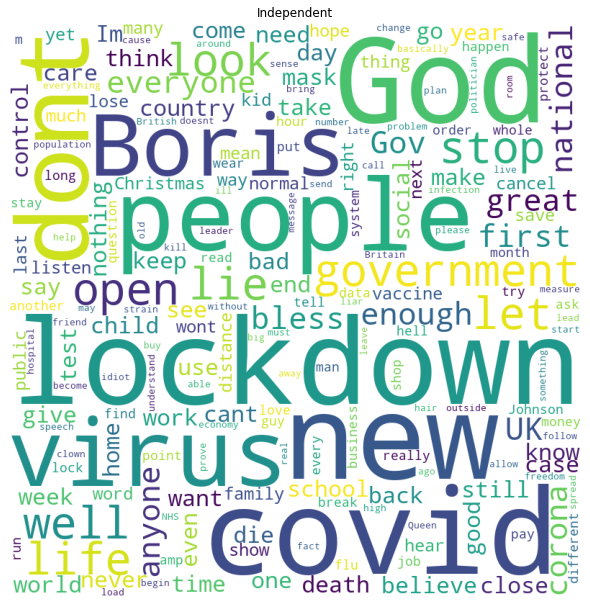

In [ ]:
getTopicsByLda(independtComments,"Independent")


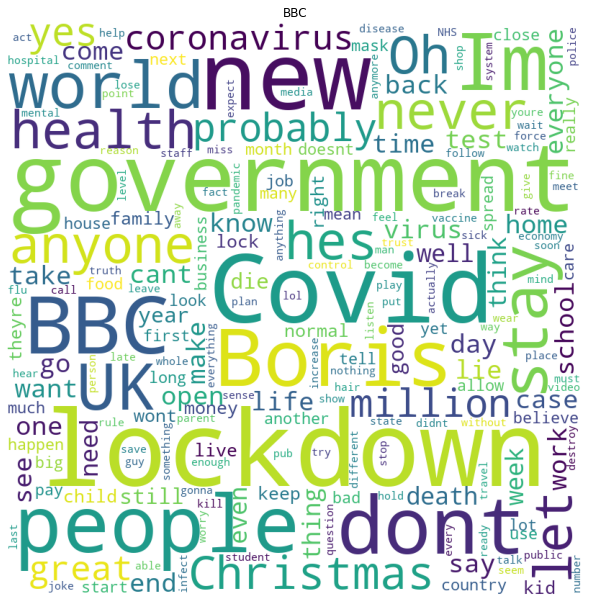

In [53]:
getTopicsByLda(bbcComments,"BBC")

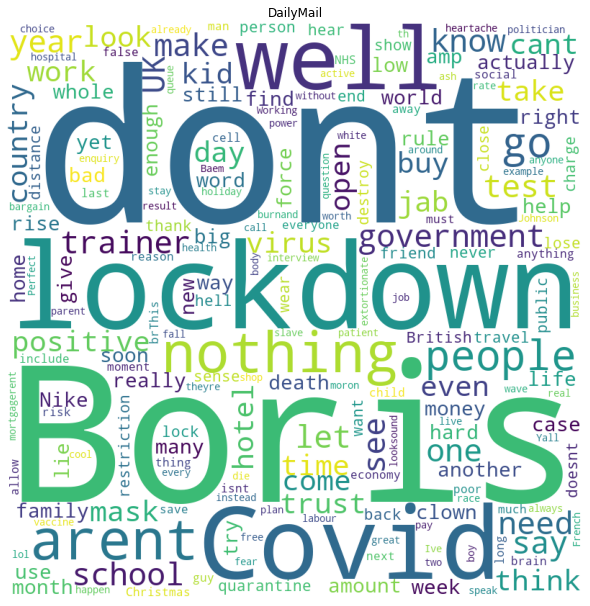

In [54]:
getTopicsByLda(dailymailComments,"DailyMail")

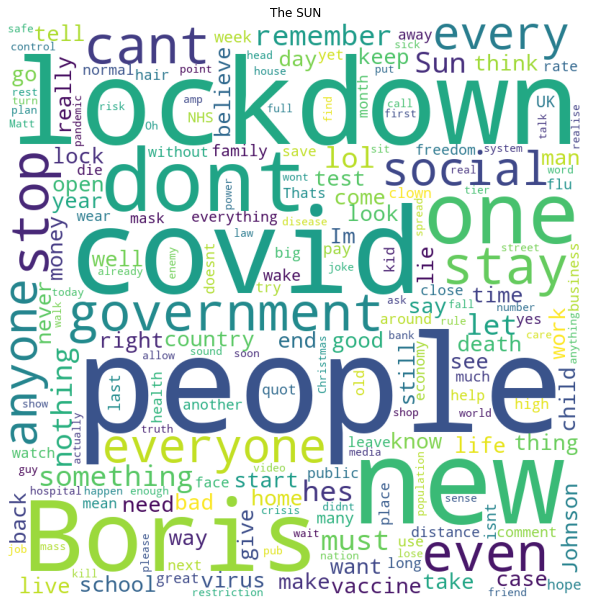

In [55]:
getTopicsByLda(theSunComments,"The SUN")

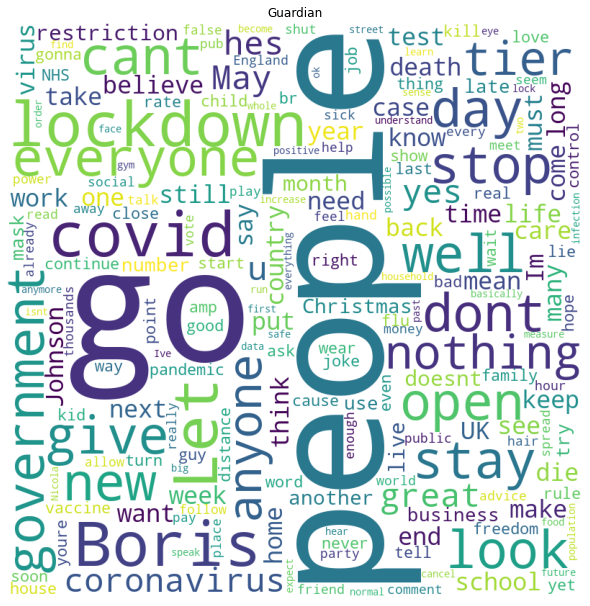

In [56]:
getTopicsByLda(guardianComments,"Guardian")

In [32]:
!pip3 install -I  matplotlib pandas wordcloud

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     |████████████████████████████████| 7.3 MB 13.4 MB/s            
     |████████████████████████████████| 11.3 MB 15.9 MB/s            
     |████████████████████████████████| 220 kB 20.3 MB/s            
  Preparing metadata (setup.py) ... done
  Using cached Pillow-8.4.0-cp39-cp39-macosx_10_10_x86_64.whl (3.0 MB)
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Using cached pyparsing-3.0.6-py3-none-any.whl (97 kB)
  Using cached numpy-1.21.5-cp39-cp39-macosx_10_9_x86_64.whl (17.0 MB)
     |████████████████████████████████| 890 kB 28.0 MB/s            
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.3.2-cp39-cp39-macosx_10_9_x86_64.whl (61 kB)
  Using cached python_dateutil-2.8.2-py2.